Author: Elizabeth Luong

Date: 26 March 2025

## Q1

#### 1.2

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfinv does not provide a C implementation. As well as being potent

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op erfinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/opt/conda/lib/python3.1

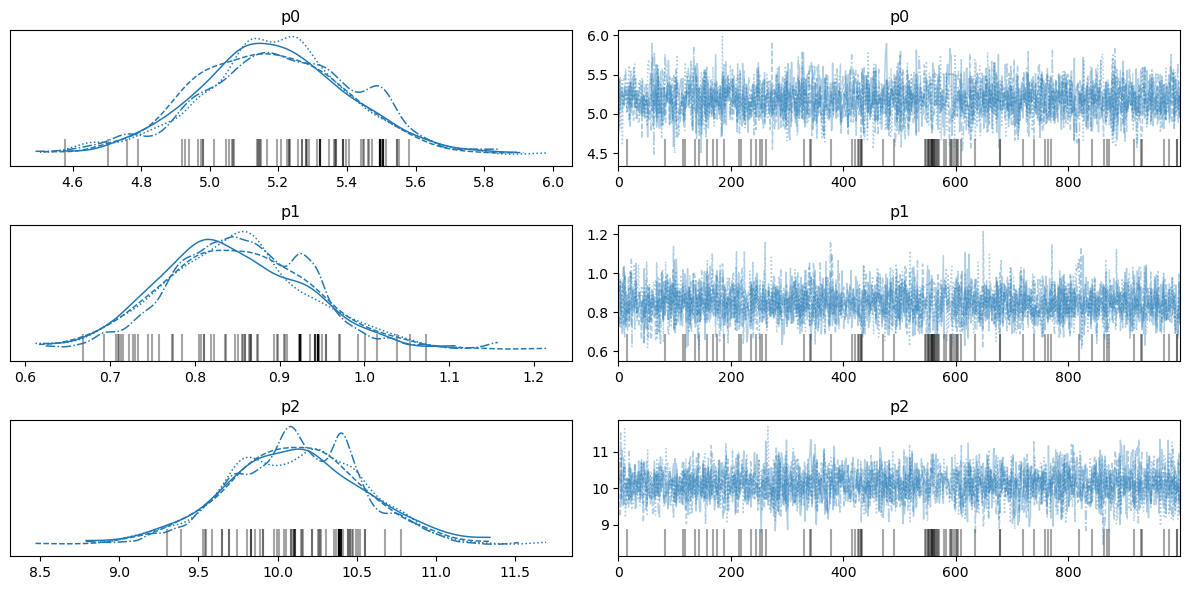

Shape of extracted correlation matrices: (3, 3)
Reshaped correlation matrices shape: (3, 3)


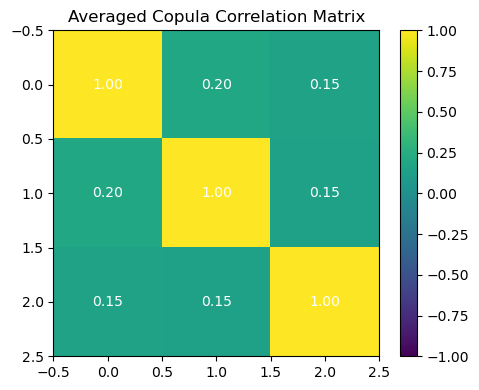

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as at

# Generate Correlated Normal Data
p = 3
a_cor = (np.ones((p, p)) * 9 + np.diag((1, 1, 1))) / 10
a_cor[0, -1] -= 0.15
a_cor[-1, 0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)

# Apply marginal transformations
y = x.copy()
y[:, 0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:, 0]))
y[:, 1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:, 1]))
y[:, 2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:, 2]))

# Fit the Copula Model using Two-Pass Approach
with pm.Model() as copula_model:
    # Define priors for marginal distributions
    p0 = pm.HalfNormal('p0', sigma=10)
    p1 = pm.HalfNormal('p1', sigma=10)
    p2 = pm.HalfNormal('p2', sigma=10)

    # Observed distributions
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:, 0])
    y1 = pm.Exponential('y1', lam=p1, observed=y[:, 1])
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:, 2])

    # Transform observed data to uniform [0,1] using log CDF
    u0 = pm.math.sigmoid(pm.logcdf(y0, pm.Gamma.dist(alpha=p0, beta=1)))
    u1 = pm.math.sigmoid(pm.logcdf(y1, pm.Exponential.dist(lam=p1)))
    u2 = pm.math.sigmoid(pm.logcdf(y2, pm.ChiSquared.dist(nu=p2)))

    # Apply inverse-normal transform to standard normal space
    norm0 = pm.Deterministic('norm0', at.erfinv(2 * u0 - 1) * np.sqrt(2))
    norm1 = pm.Deterministic('norm1', at.erfinv(2 * u1 - 1) * np.sqrt(2))
    norm2 = pm.Deterministic('norm2', at.erfinv(2 * u2 - 1) * np.sqrt(2))

    # LKJ prior for correlation structure
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0, shape=3),
                                   compute_corr=True)

    # Convert transformed copula data to NumPy before passing to MvNormal
    copula_data = np.column_stack([
        norm0.eval(), norm1.eval(), norm2.eval()
    ])

    # Define the multivariate normal copula model
    pm.MvNormal("copula", mu=np.zeros(3), chol=L, observed=copula_data)

    # Sampling
    trace = pm.sample(1000, tune=1000, chains=4, return_inferencedata=True)

# Diagnostics
az.plot_trace(trace, var_names=["p0", "p1", "p2"])
plt.tight_layout()
plt.show()

# Debug: Print shape of the extracted correlation matrices
correlation_matrices = trace.posterior['R_corr'].mean(dim=['chain', 'draw']).values
print("Shape of extracted correlation matrices:", correlation_matrices.shape)

# Ensure correct reshaping for imshow
if correlation_matrices.shape[-2:] == (3, 3):  # If already 3x3, use directly
    reshaped_corr_matrices = correlation_matrices
else:
    reshaped_corr_matrices = correlation_matrices.reshape(-1, 3, 3)  # Reshape correctly

# Debug: Print shape after reshaping
print("Reshaped correlation matrices shape:", reshaped_corr_matrices.shape)

# Plot the single averaged correlation matrix
plt.figure(figsize=(5, 4))
avg_corr_matrix = trace.posterior['R_corr'].mean(dim=["chain", "draw"]).values
im = plt.imshow(avg_corr_matrix, cmap="viridis", vmin=-1, vmax=1)
plt.title("Averaged Copula Correlation Matrix")

# Add text labels
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{avg_corr_matrix[i, j]:.2f}", color="white", ha="center", va="center")

plt.colorbar(im)
plt.tight_layout()
plt.show()



#### 1.3

A copula is a statistical tool used to describe the dependence structure between random variables independently from their marginal distributions. Copulas make it possible to construct multivariate distributions where each variable can have a different (non-normal) marginal, while still modeling the joint correlation among them. This is particularly useful when the data exhibits non-Gaussian behavior (e.g., skewed or heavy-tailed), but dependencies are still important to model. 

**First approach (Single-Pass):**

The original code uses a joint model, where:

- Each marginal is estimated with its corresponding distribution (`Gamma`, `Exponential`, `ChiSqaured`).

- The variables are transformed to a standard normal space using a combination of log-CDF and the inverse normal (`Normal.icdf`).

- A multivariable Gaussain (`MvNormal`) with an LKJ prior on the correlation matrix is used for joint modeling, via a `Potential`.

This strategy estimates everything in a single model, but can be hard to debug or tune due to entanged marginals and joint structures. 

**Second Approach (Two-Pass)**

The two-pass approach separates the problem:

1. First pass: Estimate marginal parameters independently, transform observations to uniform using `logcdf`, then to standard normal using inverse CDF.

2. Second pass: Fit a copula model to the transformed data using `MvNormal` and the LKJChloeskyCov prior.

This modular method simplifies modeling and increases flexibility and interpretability.


#### 1.4

Copulas are especially powerful for creating multivariate generalized linear models (GLMs), where:

- You have multiple response variables, each potentially with a different distribution (e.g., Poisson, Gamma, Binomial).

- You want to retain dependency between those responses -- copulas allow this via a shared latent space.

- You gain modeling flexibility: for example $y_1 \sim \text{Poisson}$, $y_2 \sim \text{Gamma}$, $y_3 \sim \text{Bernoulli}$, all linked via a Gaussian copula.

To achieve this:

1. Fit each marginal GLM individually.

2. Transform the predicted outcomes into the uniform space (using model CDF).

3. Use the copula to jointly model dependencies, typically in standard normal space.

4. Estimate or sample from the resulting multivariate model.

This is helpful for:

- Bayesian multivariate regression

- Joint prediction problems

- Modeling interactions in heterogeneous data


## Q2

In [6]:
!pip install aesara

  Using cached aesara-2.9.4-py3-none-any.whl.metadata (2.6 kB)
Using cached aesara-2.9.4-py3-none-any.whl (1.4 MB)


In [7]:
import aesara.tensor as at  # instead of pytensor.tensor as pt


In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

# Set random seed for reproducibility
np.random.seed(42)

n, p = 100, 10 # Number of observations and predictors 

# Design matrix with standard normal predictors
X = np.random.randn(n, p) 

true_beta = np.array([3, 1.5, 0, 0, 2, 0, 0, 0, 0, 0]) # True coefficients

# Generate response variable with some noise
y = X @ true_beta + np.random.randn(n)

In [3]:
#Spike-and-Slab model

with pm.Model() as ss_model:
    # Hyperparameters
    inclusion = pm.Bernoulli('inclusion', p=0.5, shape=p)
    
    # Spike-and-slab prior for coefficients
    beta_raw = pm.Normal('beta_raw', mu=0, sigma=1, shape=p)
    beta = pm.Deterministic('beta', beta_raw * inclusion)
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    trace_ss = pm.sample(1000, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [inclusion]
>NUTS: [beta_raw, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


In [4]:
# Diffuse Normal prior model

with pm.Model() as dn_model:
    # Diffuse normal prior for coefficients
    beta = pm.Normal('beta', mu=0, sigma=10, shape=p)
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    trace_dn = pm.sample(1000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


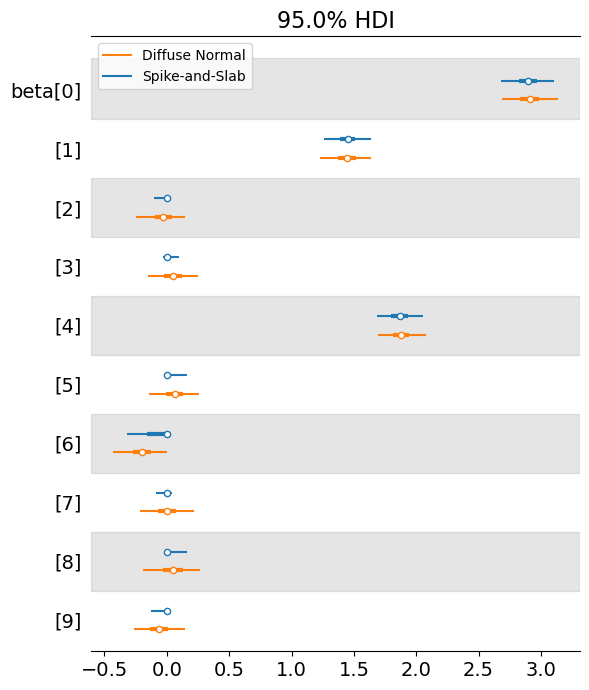

In [5]:
# Now plot comparison
az.plot_forest(
    [trace_ss, trace_dn],
    model_names=['Spike-and-Slab', 'Diffuse Normal'],
    var_names='beta',
    combined=True,
    hdi_prob=0.95
)
plt.tight_layout()
plt.show()

In this analysis, we compared spike-and-slab priors to diffuse normal priors in a multivariate regression setting. The spike-and-slab approach effectively performed variable selection by pushing irrelevant coefficients toward zero while allowing important ones to remain, resulting in narrower credible intervals for non-informative predictors. In contrast, diffuse normal priors (e.g., Normal(0, 10)) imposed minimal L2 regularization and retained all predictors regardless of relevance, leading to wider posterior intervals and less interpretability. To manage computational demands, we reduced the dataset size. Computational complexity scales linearly with the number of observations $n$, quadratically or cubically with the number of outcome variables $m$ (due to covariance calculations), and can grow exponentially with the number of predictors $p$ under spike-and-slab priors. In practice, this makes spike-and-slab models more computationally intensive than diffuse priors, especially as dimensionality increases. Therefore, variable selection methods like spike-and-slab are powerful but require careful attention to computational scalability.

## Q3


In [6]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n = 100  # Number of observations
p = 20   # Number of predictors
true_nonzero = 5  # Number of true non-zero coefficients

# Generate predictor variables
X = np.random.normal(0, 1, size=(n, p))

# True coefficients
beta = np.zeros(p)
beta[:true_nonzero] = np.random.normal(0, 1, size=true_nonzero)

# Generate response variable with some noise
y = X @ beta + np.random.normal(0, 1, size=n)


In [7]:
import pymc as pm
import pytensor.tensor as at

# Standardize predictors
X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)

with pm.Model() as horseshoe_model:
    # Global shrinkage parameter
    tau = pm.HalfStudentT('tau', nu=2, sigma=1)
    
    # Local shrinkage parameters
    lambda_ = pm.HalfCauchy('lambda_', beta=1, shape=p)
    
    # Regression coefficients
    beta = pm.Normal('beta', mu=0, sigma=tau * lambda_, shape=p)
    
    # Error standard deviation
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    # Linear model
    mu = pm.math.dot(X_standardized, beta)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    horseshoe_trace = pm.sample(1000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambda_, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 901 divergences after tuning. Increase `target_accept` or reparameterize.


In [8]:
with pm.Model() as spike_slab_model:
    # Inclusion probabilities
    pi = pm.Beta('pi', alpha=1, beta=1)
    
    # Inclusion indicators
    gamma = pm.Bernoulli('gamma', p=pi, shape=p)
    
    # Regression coefficients
    beta = pm.Normal('beta', mu=0, sigma=1, shape=p)
    
    # Spike-and-slab coefficients
    beta_ss = pm.Deterministic('beta_ss', beta * gamma)
    
    # Error standard deviation
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    # Linear model
    mu = pm.math.dot(X_standardized, beta_ss)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    spike_slab_trace = pm.sample(1000, tune=1000, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pi, beta, sigma]
>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


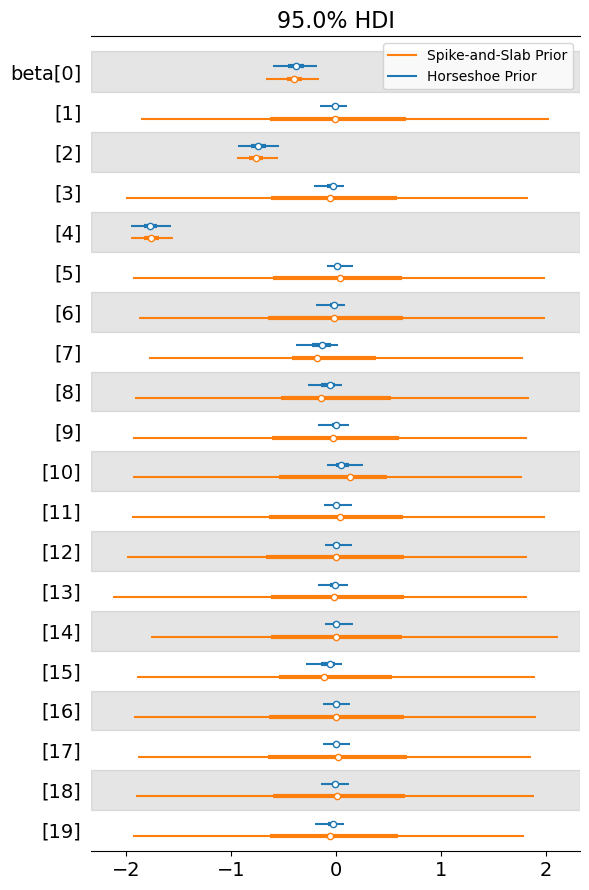

In [9]:
import arviz as az
import matplotlib.pyplot as plt

# Plot posterior distributions
az.plot_forest(
    [horseshoe_trace, spike_slab_trace],
    model_names=['Horseshoe Prior', 'Spike-and-Slab Prior'],
    var_names=['beta'],
    combined=True,
    hdi_prob=0.95
)

plt.tight_layout()
plt.show()

In [ ]:
S